In [1]:
from attention import AttentionLayer

In [2]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("Reviews.csv",nrows=50000)

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [6]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [7]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [8]:
cleaned_text[:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [9]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [10]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [11]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [12]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

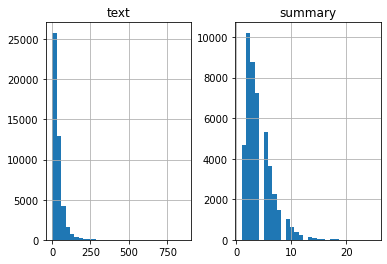

In [13]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [14]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9439323119536052


In [15]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 30):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.5587076949710033


In [16]:
max_text_len=30
max_summary_len=8

In [17]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [18]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok


In [19]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True) 

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [20]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 66.12760790374213
Total Coverage of rare words: 4.072762119889796


In [21]:
print(cnt),print(tot_cnt)

11981
18118


(None, None)

In [22]:
print(freq),print(tot_freq)

16660
409059


(None, None)

In [23]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [24]:
x_voc

6138

In [25]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 79.91605782683041
Total Coverage of rare words: 7.357814181716485


In [27]:
print(cnt),print(tot_cnt)

5141
6433


(None, None)

In [28]:
print(freq),print(tot_freq)

8682
117997


(None, None)

In [29]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [30]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [31]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [32]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      613800      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es],
                  batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/10
115/171 [===================>..........] - ETA: 1:02 - loss: 2.9270

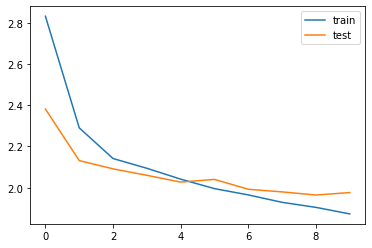

In [36]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [37]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [38]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [39]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [40]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [41]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: know cannot make tea good south know never enjoyed tea sweet without sweet tastes crisp 
Original summary: this is the best 
1/1 [==============================] - 0s 13ms/step
Predicted summary:  great coffee


Review: disappointing folks like say tofu flavor type watery product buy soon got shopping awful disappointing benefits packaging shelf life 
Original summary: soft for tofu 
1/1 [==============================] - 0s 12ms/step
Predicted summary:  great


Review: cup gf bisquick cup soy almond milk cup favorite fruit bake quick delicious gluten free bisquick quite fluffy crumbly original definitely worth gf 
Original summary: great for 
1/1 [==============================] - 0s 14ms/step
Predicted summary:  great


Review: love product best natural sweetener ever tried tried many use also pancake syrup substitute honey peanut butter honey sandwich last long time good value 
Original summary: the best 
1/1 [==============================] - 0s 12ms/step
Predicted summary: